In [1]:
%matplotlib inline


Reinforcement Learning (DQN) tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
`Gym website <https://gym.openai.com/envs/CartPole-v0>`__.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the environment terminates if the pole falls over too far.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [262]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


env = gym.make('MountainCar-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [263]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
^^^^^^^^^

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *quality* of
taking each action given the current input.




In [293]:
class DQN(nn.Module):

    def __init__(self, state_dim, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Return Q values
        return x # num_actions, gives the Q value for each
        
        # return action probabilities
        #action_probs = F.softmax(x, dim=0)

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``Variable`` - this is a simple wrapper around
   ``torch.autograd.Variable`` that will automatically send the data to
   the GPU every time we construct a Variable.
-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [294]:
from torch.distributions import Categorical

In [316]:
BATCH_SIZE = 12
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(2, 3) # state_dim, num_actions
target_net = DQN(2, 3) # state_dim, num_actions
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if use_cuda:
    policy_net = policy_net.cuda()
    target_net = target_net.cuda()

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)
memory = ReplayMemory(20000) # 13361 willl be used according to my tets

In [295]:
#### Not being used here. These are for a stochastic setup

steps_done = 0

def select_action_stochastic(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        action_probs = policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
        m = Categorical(action_probs)
        action = m.sample()
        return action
    else:
        return LongTensor([[random.randrange(3)]])
    
def select_action(state):
    action_probs = policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [317]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Sample transitions from buffer
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # Select all s' that are not final
    non_final_next_states = Variable(torch.cat([FloatTensor(s) for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    
    state_batch = Variable(torch.cat([FloatTensor(s) for s in batch.state]))
    action_batch = Variable(LongTensor(batch.action))
    reward_batch = Variable(FloatTensor(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    
    # Returns [Q(s,a_1), Q(s,a_2), Q(s,a_3)] for each state
    Q_values_all_actions = policy_net(state_batch.view(BATCH_SIZE,2))
    
    # Returns [Q(s, a_i)] where a_i comes from action_batch
    Q_values_selected_actions = Q_values_all_actions.gather(1, action_batch.view(-1, 1))
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    
    #.max(1) does an argmax
    next_state_values[non_final_mask] = target_net(non_final_next_states.view(BATCH_SIZE,2)).max(1)[0]
    
    # Compute the expected Q values
    expected_Q_values_selected_actions = (next_state_values * GAMMA) + reward_batch
    
    # Undo volatility (which was used to prevent unnecessary gradients)
    expected_Q_values_selected_actions = Variable(expected_Q_values_selected_actions.data)
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(Q_values_selected_actions, expected_Q_values_selected_actions)
    print('Q_values_selected_actions')
    print(Q_values_selected_actions)
    print('expected_Q_values_selected_actions')
    print(expected_Q_values_selected_actions)

    # Optimize the model
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` variable. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes.




# Collect off-policy samples

In [41]:
from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *

## Generate samples

In [12]:
import random
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
    
class StochasticPolicy():
    def __init__(self):
        self.manual_policy = ManualPolicy()
        self.random_policy = RandomPolicy2(choices=[0, 2]) # left, right

    def choose_action(self, s):
        if random.random() < 0.25:
            return self.random_policy.choose_action(s)
        else:
            return self.manual_policy.choose_action(s)
    
pi4 = ManualPolicy()

# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right

# for offline dqn
pi6 = StochasticPolicy()

In [13]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

In [14]:
trajs_for_dqn = sim.simulate(pi4, n_trial=1, n_episode=100)

In [17]:
print("dimensions of trajs_for_dqn = {0} x ~{1}".format(len(trajs_for_dqn), len(trajs_for_dqn[0])))

dimensions of trajs_for_dqn = 100 x ~162


In [232]:
num_transitions = 0
for episode in trajs_for_dqn:
    num_transitions += len(episode)
print("number of transitions in trajs_for_dqn = {0}".format(num_transitions))

number of transitions in trajs_for_dqn = 13361


In [233]:
print("example transition: {0}".format(trajs_for_dqn[0][0]))

example transition: Transition(s=array([-0.51256768,  0.        ]), a=0, r=-1.0, s_next=array([-0.51365039, -0.00108272]), done=False)


# Train!

### In our approach, we store *all* transition in the replay buffer.

In [318]:
for episode in trajs_for_dqn:
    for transition in episode:
        # Store the transition in memory
        memory.push(transition.s, transition.a, transition.s_next, transition.r)

In [ ]:
loss = []

In [306]:
3 % 1

0

In [319]:

NUM_ITERATIONS = 50000
for iteration in range(NUM_ITERATIONS):
    loss.append(optimize_model().data[0])
    if iteration % 1 == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if iteration % (NUM_ITERATIONS / 100) == 0:
        print("iteration {0}: loss = {1}".format(iteration, loss[-1]))

Q_values_selected_actions
Variable containing:
 0.0000
 0.0000
 0.1643
 0.1195
 0.0000
 0.0000
 0.1608
 0.1395
 0.1464
 0.1431
 0.1310
 0.0000
[torch.cuda.FloatTensor of size 12x1 (GPU 0)]

expected_Q_values_selected_actions
Variable containing:
-0.7070
-0.8248
-0.7656
-0.8299
-0.7683
-0.7775
-0.7632
-0.7990
-0.7872
-0.7929
-0.8130
-0.9321
[torch.cuda.FloatTensor of size 12 (GPU 0)]

iteration 0: loss = 0.3909686803817749
Q_values_selected_actions
Variable containing:
 0.1268
 0.1264
 0.0000
 0.0000
 0.1408
 0.0000
 0.1374
 0.1391
 0.0000
 0.0588
 0.0000
 0.0679
[torch.cuda.FloatTensor of size 12x1 (GPU 0)]

expected_Q_values_selected_actions
Variable containing:
-0.7935
-0.7941
-0.8881
-0.8919
-0.7729
-0.9525
-0.7773
-0.7746
-0.8279
-0.9404
-0.7922
-0.9228
[torch.cuda.FloatTensor of size 12 (GPU 0)]

Q_values_selected_actions
Variable containing:
 0.0000
 0.1503
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.1239
[torch.cuda.FloatTensor of size 12x1 (GPU 0)

KeyboardInterrupt: 

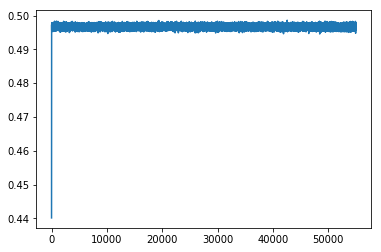

In [301]:
plt.plot(range(len(loss)), loss)

# Test!

In [268]:
# Create a wrapper for the agent
# Wrapper so that choose_action is exposed
class Dqn_wrapper(object):
    def __init__(self, policy_net):
        self.policy_net = policy_net
    
    def choose_action(self, s):
        action = self.policy_net(Variable(FloatTensor(s))).max(0)[1]
        return action

In [291]:
policy_net(Variable(FloatTensor(env.observation_space.sample())))#.max(0)[1]

Variable containing:
 0
 0
 0
[torch.cuda.FloatTensor of size 3 (GPU 0)]

In [269]:
pi_dqn = Dqn_wrapper(policy_net)

In [274]:
pi_dqn.choose_action(env.observation_space.sample())

Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [ ]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()